In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d
import numpy as np
from dtw import dtw
from data_copying_tests import C_T
from sklearn.cluster import KMeans

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
os.chdir(os.path.expanduser('~/git/mf-copula'))

In [3]:
def plot_subplots(df):
    _, ax = plt.subplots(1, 3, figsize=(18,8))

    ax[0].plot(df.X, df.Y, c='C3')
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')

    ax[1].plot(df.X, df.Z, c='C3')
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Z')

    ax[2].plot(df.Y, df.Z, c='C3')
    ax[2].set_xlabel('Y')
    ax[2].set_ylabel('Z')

def plot_3d(df_list):

    fig = plt.figure(figsize=(8, 6))

    ax = fig.add_subplot(111, projection='3d')

    for i, df in enumerate(df_list):
        ax.plot(df.X, df.Y, df.Z, label='3D Path', color=f'C{i % 10}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


In [4]:
def load_synthetic(synthetic_csv):
    data = []

    for csv in os.listdir(synthetic_csv):
        if csv != 'original.csv':
            data.append(pd.read_csv(os.path.join(synthetic_csv, csv)))

    X = [df[['X', 'Y', 'Z']].interpolate() for df in data]
    
    return X

def plot_synthetic(synthetic_csv):
    X = load_synthetic(synthetic_csv)

    fig = plt.figure(figsize=(14, 12))

    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for df in X:
        ax.scatter(df.X, df.Y, df.Z, label='3D Path', color='C2', alpha=0.1)  # Using color 'C3' for consistency

def plot_overlay(T, Q, Pn=None, ax=None):
    X = load_synthetic(Q)

    if ax is None:
        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for df in X:
        ax.plot(df.X, df.Y, df.Z, color='C2', alpha=0.1)  # Using color 'C3' for consistency

    df = pd.read_csv(T)
    ax.plot(df.X, df.Y, df.Z, label='$T$', color='C3', linewidth=3, zorder=5)

    if Pn is not None:
        ax.plot(Pn.X, Pn.Y, Pn.Z, label='$P_n$', color='C4', linewidth=3, zorder=4)

    ax.plot([], [], [], label='$Q$', color='C2')
    # ax.legend()

    return X


In [5]:
def mean_path(df):

    return pd.DataFrame({
        'X': pd.concat(df, axis=1)[['X']].mean(axis=1),
        'Y': pd.concat(df, axis=1)[['Y']].mean(axis=1),
        'Z': pd.concat(df, axis=1)[['Z']].mean(axis=1)
        })

def dtw_variation(X):
    dtw_dist = []
    mean_path_X = mean_path(X)

    for df in X:
        dtw_dist.append(dtw(mean_path_X, df).distance)

    return np.mean(dtw_dist)

def pairwise_distance_matrix(X):
    n_samples = len(X)
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            distances[i, j] = dtw(X[i], X[j]).distance
            distances[j, i] = distances[i, j]
    return distances

In [6]:
def C_T_reshaped(Pn, Qm, T, tau=0, dim=10, n_clusters=5):
    T_reshaped = T.to_numpy()[:(-(T.shape[0] % dim) if T.shape[0] % dim > 0 else T.shape[0])].reshape(-1, dim)
    Pn_reshaped = Pn.to_numpy()[:(-(Pn.shape[0] % dim) if Pn.shape[0] % dim > 0 else Pn.shape[0])].reshape(-1, dim)
    Qm_reshaped = Qm.to_numpy()[:(-(Qm.shape[0] % dim )if Qm.shape[0] % dim > 0 else Qm.shape[0])].reshape(-1, dim)

    if np.any(np.array([T_reshaped.shape[0], Pn_reshaped.shape[0], Qm_reshaped.shape[0]]) == 0):
        print([T.shape, Pn.shape, Qm.shape])
        print([T_reshaped.shape, Pn_reshaped.shape, Qm_reshaped.shape])
        exit()

    KM = KMeans(n_clusters).fit(T_reshaped)

    T_labels = KM.predict(T_reshaped)
    Pn_labels = KM.predict(Pn_reshaped)
    Qm_labels = KM.predict(Qm_reshaped)

    return C_T(Pn_reshaped, Pn_labels, Qm_reshaped, Qm_labels, T_reshaped, T_labels, tau)


def C_T_agg(Pn, Qm_agg, T, tau=0, dim=1, n_clusters=5):
    C_Ts = []

    if dim == 1:
        KM = KMeans(n_clusters).fit(T)

        T_labels = KM.predict(T)
        Pn_labels = KM.predict(Pn)
        
        for Qm in Qm_agg:
            Qm_labels = KM.predict(Qm)
            C_Ts.append(C_T(Pn, Pn_labels, Qm, Qm_labels, T, T_labels, tau))
    else:
        for Qm in Qm_agg:
            C_Ts.append(C_T_reshaped(Pn, Qm, T, tau, dim, n_clusters))

    return np.mean(C_Ts), np.var(C_Ts)

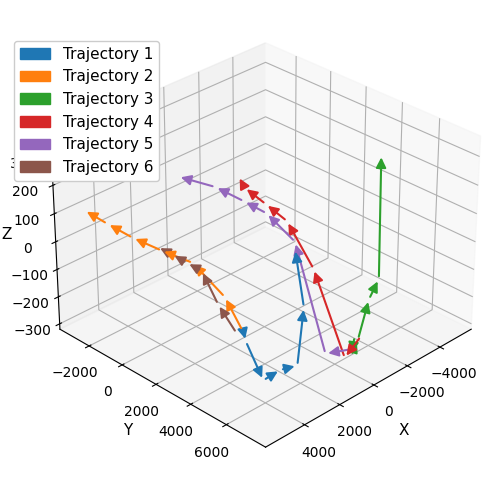

In [7]:
# Define a 3D arrow class
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# Load and plot paths
dir = './HNTT/preprocessed/hybrid/'
paths = []
legend_handles = []
NUM_PATHS = 10

for i, csv in enumerate(os.listdir(dir)):
    if i > NUM_PATHS:
        break
    if csv.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir, csv))
        paths.append(df)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i, df in enumerate(paths):
    # Plot the trajectory line
    ax.plot(df.X, df.Y, df.Z, color=f'C{i % 10}', lw=1.5, alpha=0)

    legend_handles.append(mpatches.Patch(color=f'C{i % 10}', label=f'Trajectory {i+1}'))
    
    # Add arrows at regular intervals
    n = max(1, len(df) // 6)  # Show an arrow every 1/6 of the path
    
    for j in range(0, len(df)-n, n):
        # Start and end points for this arrow
        x1, y1, z1 = df.X.iloc[j], df.Y.iloc[j], df.Z.iloc[j]
        x2, y2, z2 = df.X.iloc[j+n], df.Y.iloc[j+n], df.Z.iloc[j+n]
        
        # Create and add the arrow
        arrow = Arrow3D(
            [x1, x2], [y1, y2], [z1, z2],
            mutation_scale=15,  # arrow size
            lw=1.5,             # line width
            arrowstyle='-|>',   # arrow style
            color=f'C{i % 10}',
            alpha=1,
            label=f'Trajectory {i}'
        )
        ax.add_artist(arrow)

ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
ax.set_zlabel('Z', fontsize=11, labelpad=-1)
ax.view_init(elev=30, azim=45)

ax.legend(handles=legend_handles, bbox_to_anchor=(0.3, 0.95), fontsize=11, framealpha=1)
plt.subplots_adjust(wspace=0, hspace=0)
# fig.savefig('./img/ntt-data.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

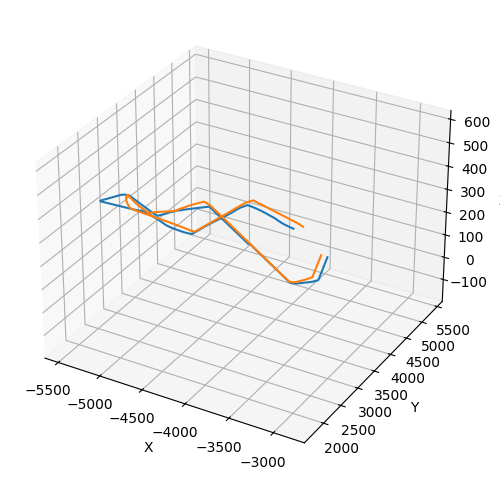

In [ ]:
dir = './HNTT/preprocessed/human/'

T = pd.read_csv(os.path.join(dir, '2021.01.25-12.12.54.csv'))

P = []
for csv in os.listdir(dir):
    df = pd.read_csv(os.path.join(dir, csv))
    if df.shape[1] > 1:
        P.append(df)
                     
P = [Pi for Pi in P if Pi.shape[1] > 1 and not Pi.equals(T)]
P_dist = np.array([dtw(T, P_i).distance for P_i in P])
Pn = P[np.argmin(P_dist)]

plot_3d([T, Pn])

In [9]:
pprint = lambda x: f'{x[0]:7.2f}\t{x[1]:7.2f}\t{np.sqrt(x[1])/x[0]:7.2f}'

DTW-Var: 46269.97
               Mean	    Var	     CV
CT-5-10:     -4.68	   0.15	  -0.08
CT-10-10:     -2.37	   0.07	  -0.11
CT-15-10:     -1.64	   0.09	  -0.18


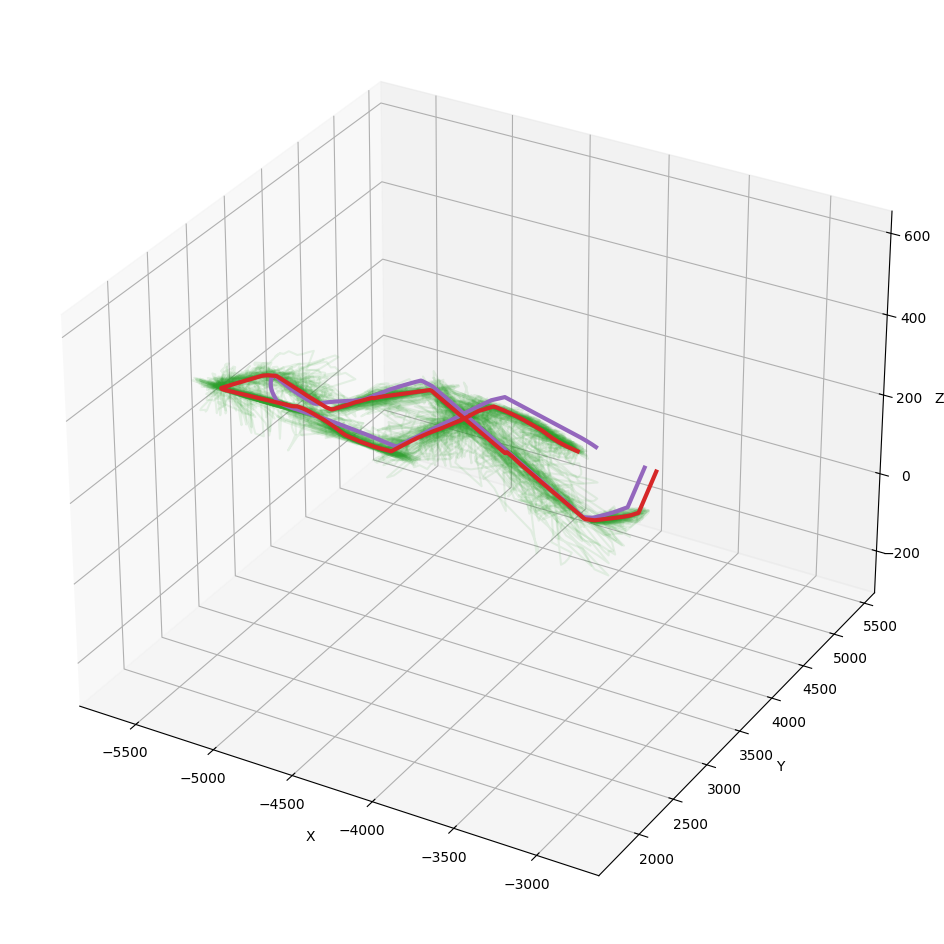

In [10]:
Q = plot_overlay(
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-10/original.csv',
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-10/',
    Pn
)

mask = np.loadtxt('./HNTT/preprocessed/human/2021.01.25-12.12.54-mask.txt', dtype=int)
n_clusters = len(mask)
print(f'DTW-Var: {dtw_variation(Q):7.2f}')
print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=5, n_clusters=n_clusters))}')
print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=10, n_clusters=n_clusters))}')
print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=15, n_clusters=n_clusters))}')

DTW-Var: 89505.70
               Mean	    Var	     CV
CT-5-10:     -2.21	   0.20	  -0.20
CT-10-10:     -0.50	   0.09	  -0.61
CT-15-10:      0.15	   0.11	   2.19


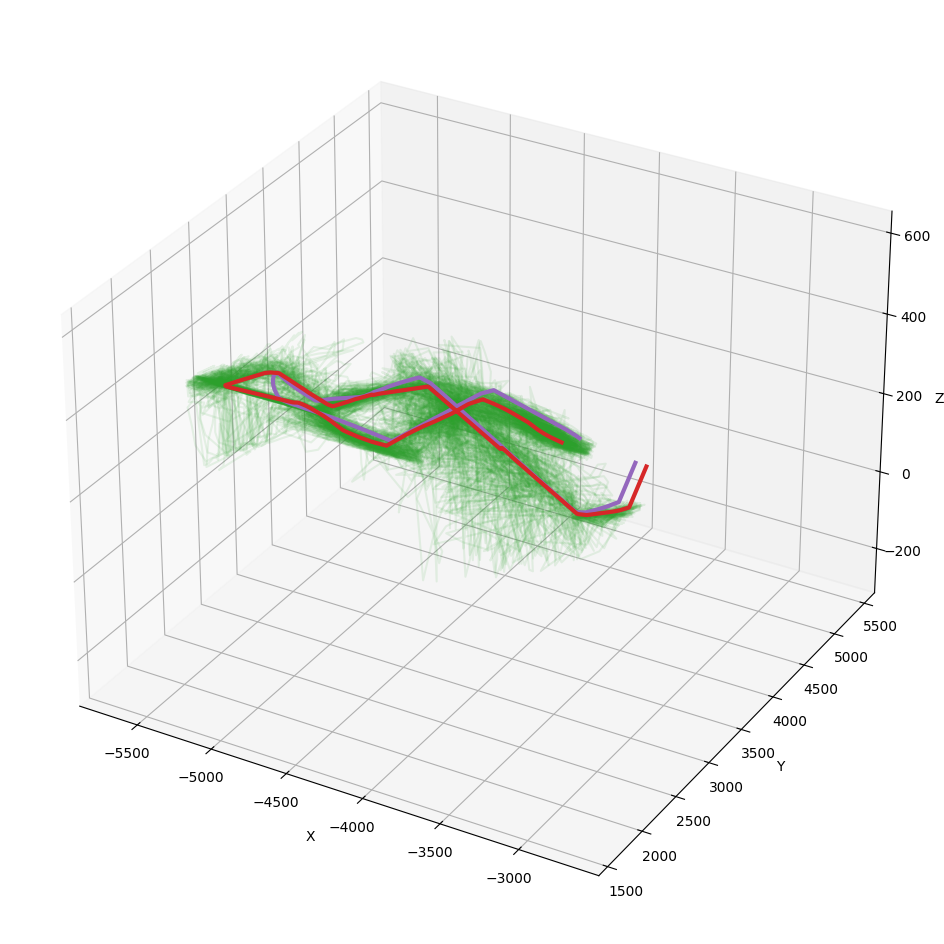

In [11]:
Q = plot_overlay(
    './synthetic/output/2021.01.25-12.12.54-mf-ban5-chol2-50/original.csv',
    './synthetic/output/2021.01.25-12.12.54-mf-ban5-chol2-50/',
    Pn
)

mask = np.loadtxt('./HNTT/preprocessed/human/2021.01.25-12.12.54-mask.txt', dtype=int)
n_clusters = len(mask)
print(f'DTW-Var: {dtw_variation(Q):7.2f}')
print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=5, n_clusters=n_clusters))}')
print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=10, n_clusters=n_clusters))}')
print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=15, n_clusters=n_clusters))}')

DTW-Var: 158812.02
               Mean	    Var	     CV
CT-5-10:      1.04	   0.27	   0.50
CT-10-10:      1.35	   0.10	   0.23
CT-15-10:      1.26	   0.10	   0.25


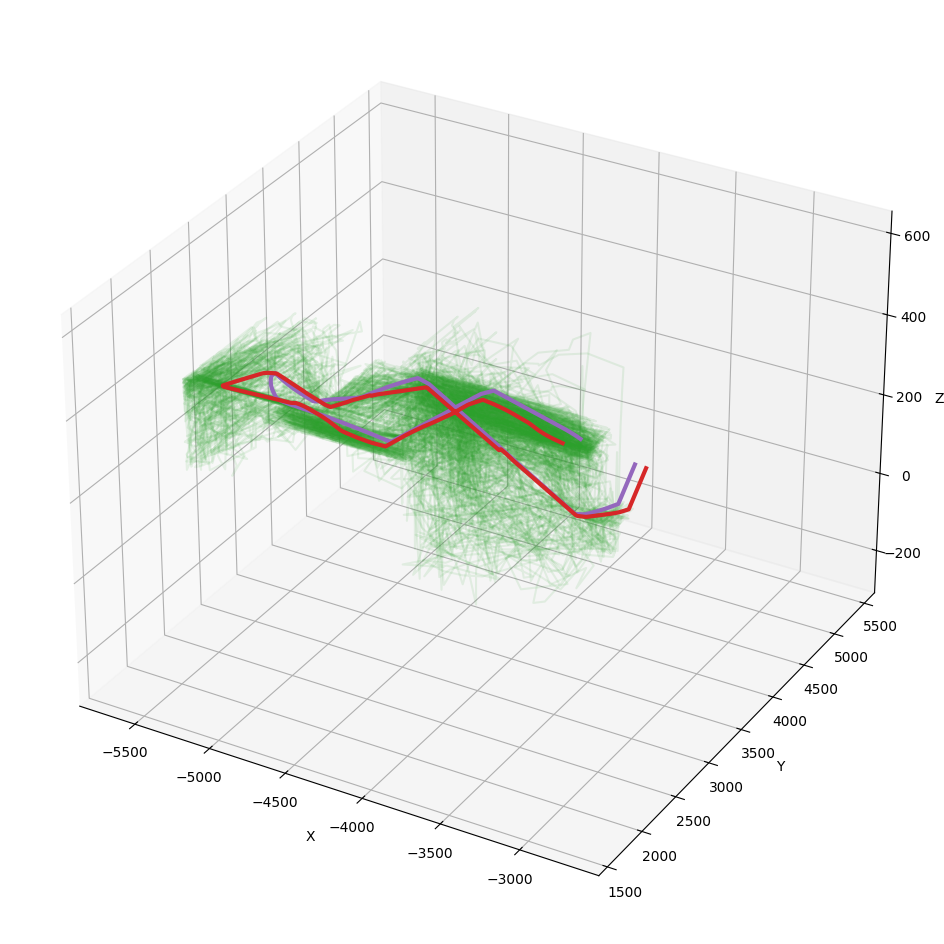

In [12]:
Q = plot_overlay(
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-150/original.csv',
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-150/',
    Pn
)

mask = np.loadtxt('./HNTT/preprocessed/human/2021.01.25-12.12.54-mask.txt', dtype=int)
n_clusters = len(mask)
print(f'DTW-Var: {dtw_variation(Q):7.2f}')
print(f'            {"Mean":>7}\t{"Var":>7}\t{"CV":>7}')
print(f'CT-5-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=5, n_clusters=n_clusters))}')
print(f'CT-10-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=10, n_clusters=n_clusters))}')
print(f'CT-15-{n_clusters}:   {pprint(C_T_agg(Pn, Q, T, tau=0, dim=15, n_clusters=n_clusters))}')

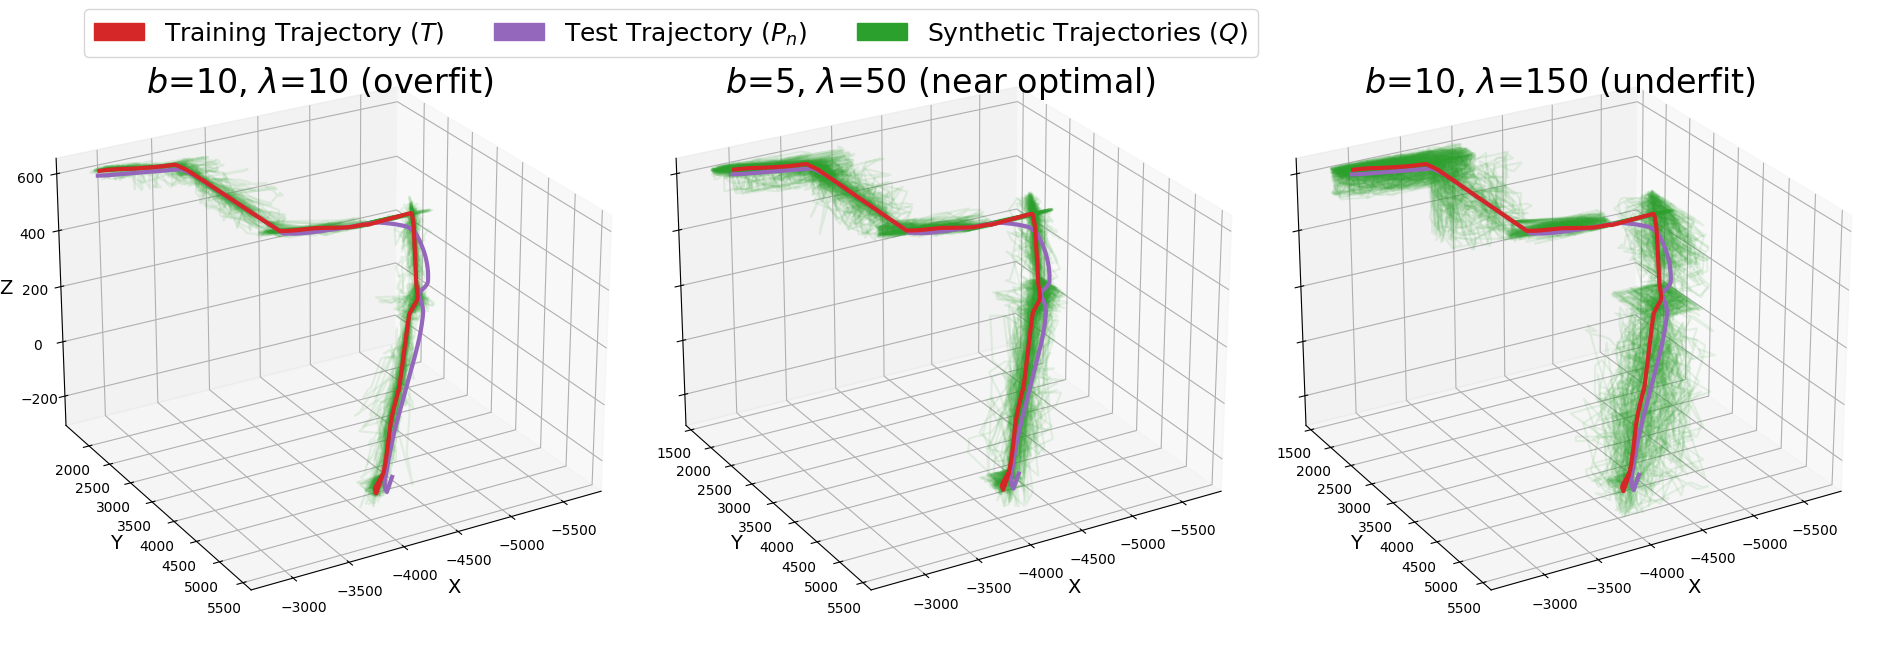

In [13]:
fig = plt.figure(figsize=(24, 12))
plt.subplots_adjust(wspace=0, hspace=0)

ELEV = 25 # 60 # 10 #  20 # 30
AZIM = 60 # 30 # 45 # -35 # 45

ax = fig.add_subplot(131, projection='3d')
ax.set_title('$b$=10, $\lambda$=10 (overfit)', x=0.5, y=0.95, fontsize=24)
plot_overlay(
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-10/original.csv',
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-10/',
    Pn,
    ax=ax
)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', labelpad=3.5, fontsize=14)
ax.view_init(elev=ELEV, azim=AZIM)

ax = fig.add_subplot(132, projection='3d')
ax.set_title('$b$=5, $\lambda$=50 (near optimal)', x=0.5, y=0.95, fontsize=24)
plot_overlay(
    './synthetic/output/2021.01.25-12.12.54-mf-ban5-chol2-50/original.csv',
    './synthetic/output/2021.01.25-12.12.54-mf-ban5-chol2-50/',
    Pn,
    ax=ax
)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('')
ax.set_zticklabels([])
ax.view_init(elev=ELEV, azim=AZIM)

ax = fig.add_subplot(133, projection='3d')
ax.set_title('$b$=10, $\lambda$=150 (underfit)', x=0.5, y=0.95, fontsize=24)
plot_overlay(
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-150/original.csv',
    './synthetic/output/2021.01.25-12.12.54-mf-ban10-chol2-150/',
    Pn,
    ax=ax
)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('')
ax.set_zticklabels([])
ax.view_init(elev=ELEV, azim=AZIM)

patch1 = mpatches.Patch(color='C3', label='Training Trajectory ($T$)')
patch2 = mpatches.Patch(color='C4', label='Test Trajectory ($P_n$)')
patch3 = mpatches.Patch(color='C2', label='Synthetic Trajectories ($Q$)')

fig = plt.gcf()
fig.legend(handles=[patch1, patch2, patch3], ncol=3, bbox_to_anchor=(0.65, 0.775), fontsize=18)
# fig.savefig('./img/ntt-experiments.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()